In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

In [38]:
image = cv2.imread('sct-50x64_512x384.png')

In [39]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    isX = True if orient == 'x' else False
    sobel = cv2.Sobel(gray, cv2.CV_64F, isX, not isX)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1

    return dir_binary

def apply_thresholds(image, ksize=3):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined

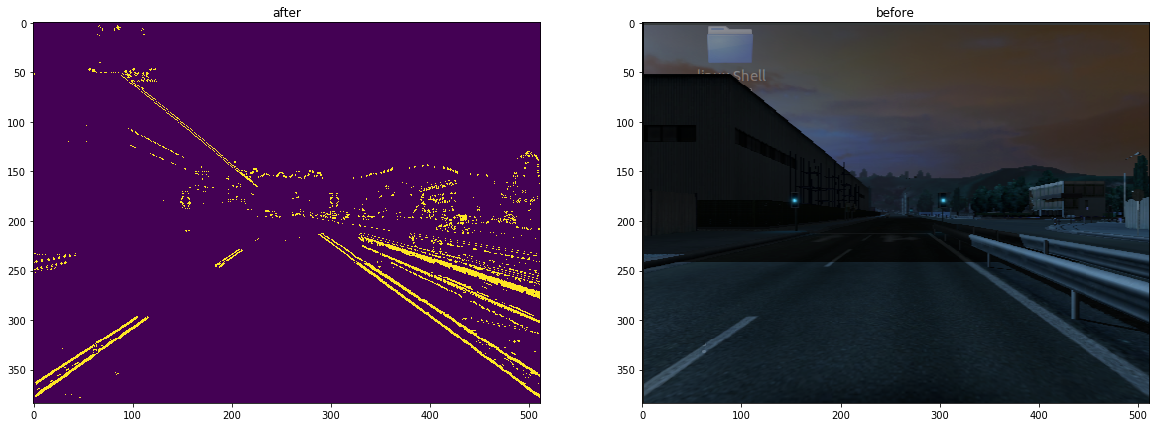

In [40]:
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(apply_thresholds(image))
plt.title('after')
plt.subplot(122),plt.imshow(image)
plt.title('before')

plt.show()

In [41]:
def select_white_yellow(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(hls, lower, upper)
    # yellow color mask
    low_yellow = np.uint8([10, 0, 100])
    up_yellow = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(hls, low_yellow, up_yellow)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    
    return mask

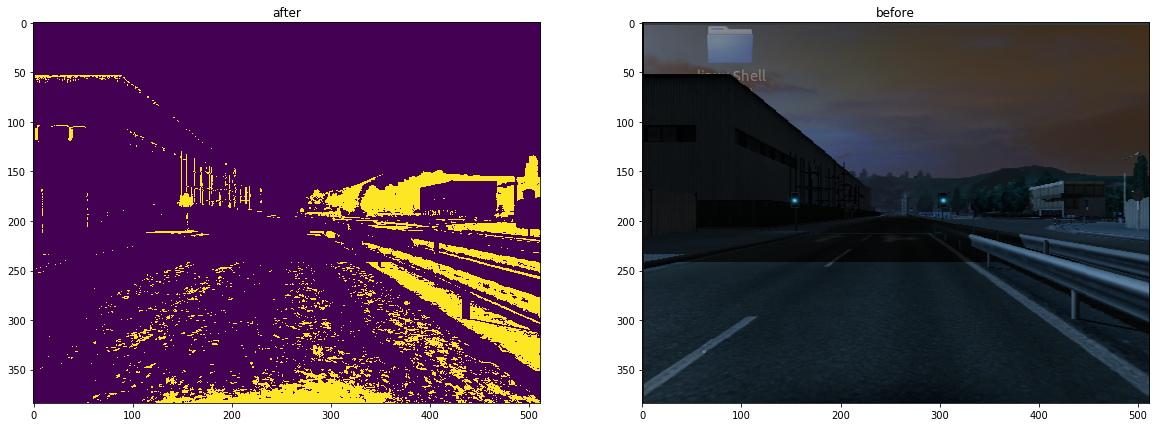

In [42]:
mask = select_white_yellow(image)
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(mask)
plt.title('after')
plt.subplot(122),plt.imshow(image)
plt.title('before')

plt.show()

In [43]:
def combine_threshold(s_binary, combined):
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary == 1) | (combined == 1)] = 1

    return combined_binary

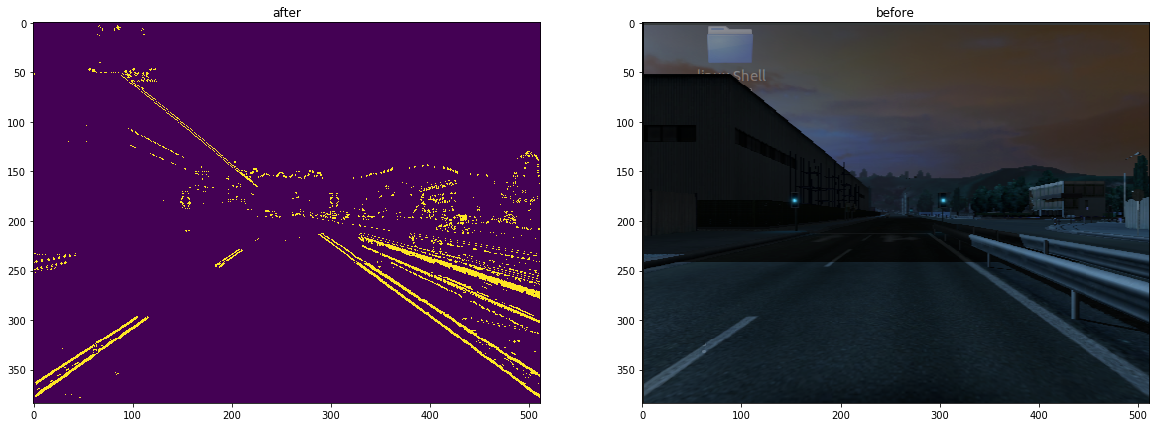

In [44]:
result = combine_threshold(select_white_yellow(image),apply_thresholds(image))
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(result)
plt.title('after')
plt.subplot(122),plt.imshow(image)
plt.title('before')

plt.show()

In [45]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import cv2
import numpy as np
import pickle as pickle
import glob

vp = [260,192]
def  find_pt_inline (p1, p2, y):
    """
    Here we use point-slope formula in order to find a point that is present on the line
    that passes through our vanishing point (vp). 
    input: points p1, p2, and y. They come is as tuples [x, y]
    We then use the point-slope formula: y - b = m(x - a)
    y: y-coordinate of desired point on the line
    x: x-coordinate of desired point on the line
    m: slope
    b: y-coordinate of p1
    a: x-coodrinate of p1
    x = p1x + (1/m)(y - p1y)
    """
    m_inv = (p2[0] - p1[0]) / float(p2[1] - p1[1])
    Δy = (y - p1[1])
    x = p1[0] + m_inv * Δy
    return [x, y]
top = vp[1] + 65
bot = 370 - 40

# Make a large width so that you can grab the lines on the challenge video
width = 500

p1 = [vp[0] - width/2, top]
p2 = [vp[0] + width/2, top]
p3 = find_pt_inline(p2, vp, bot)
p4 = find_pt_inline(p1, vp, bot)

src = np.float32([p1, p2, p3, p4])

dst = np.float32(
        [[0, 0],#0,0
        [500, 0],# _,0
        [500, 600],# _ ,*
        [0, 600]])# 0 , *


def warp(img):
    img_size = (500, 600)

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    binary_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return binary_warped, Minv

def unwarp(img,real):
    
    # Compute and apply inverse perpective transform
    img_size = (real.shape[1], real.shape[0])
    Minv = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_NEAREST)
    
    return unwarped

print(src)

[[  10.       257.     ]
 [ 510.       257.     ]
 [ 790.7692   330.     ]
 [-270.76923  330.     ]]


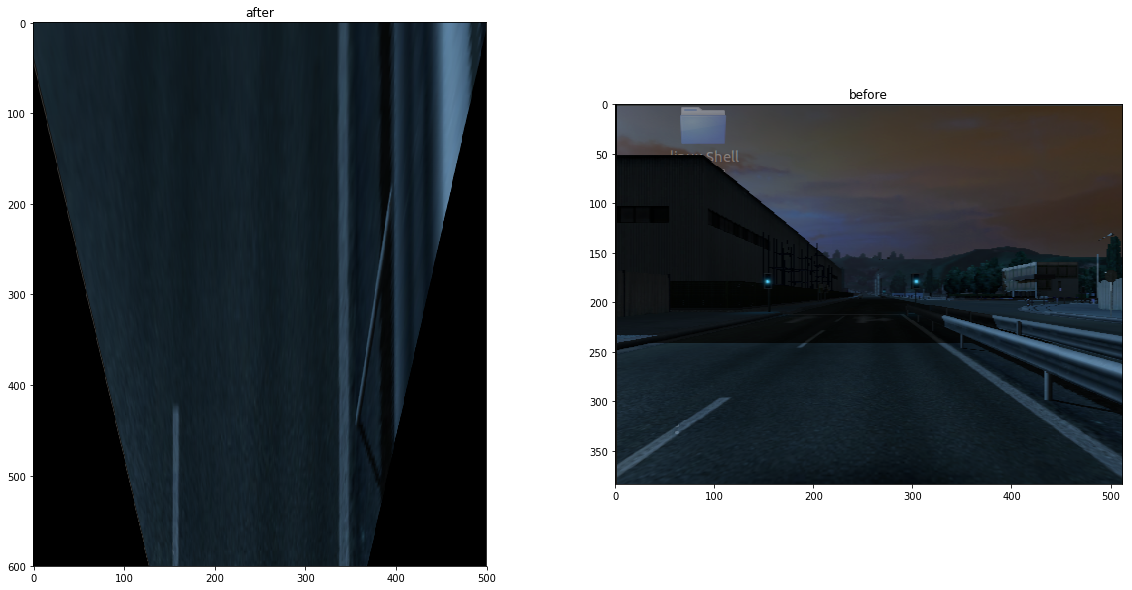

In [46]:
warped,minv = warp(image)
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(warped)
plt.title('after')
plt.subplot(122),plt.imshow(image)
plt.title('before')

plt.show()

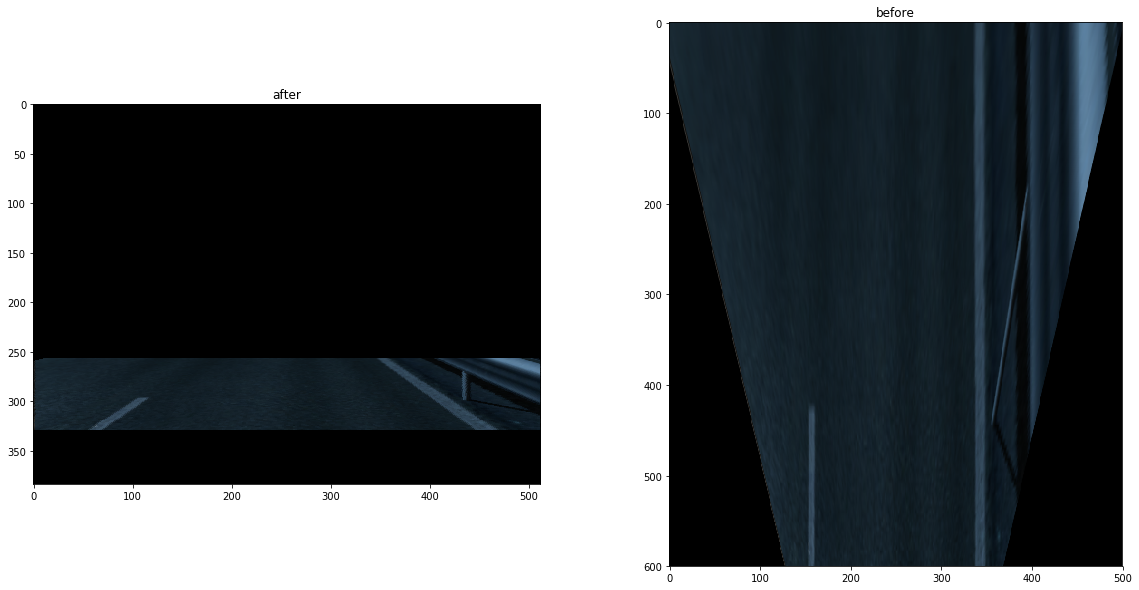

In [47]:
unwarped = unwarp(warped,image)
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(unwarped)
plt.title('after')
plt.subplot(122),plt.imshow(warped)
plt.title('before')

plt.show()

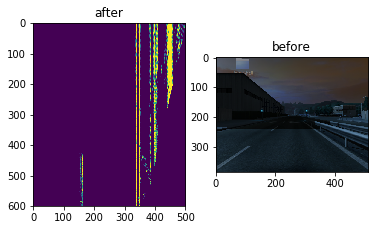

In [48]:
result = combine_threshold(select_white_yellow(image),apply_thresholds(image))
warped,minv = warp(result)
plt.subplot(121),plt.imshow(warped)
plt.title('after')
plt.subplot(122),plt.imshow(image)
plt.title('before')

plt.show()

In [49]:
def get_histogram(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    return histogram

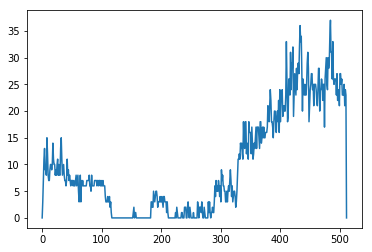

In [50]:
result = combine_threshold(select_white_yellow(image),apply_thresholds(image))
warped,minv = warp(image)
histogram = get_histogram(result)
plt.plot(histogram)


In [51]:
ym_per_pix = 3*8/720 # meters per pixel in y dimension, 8 lines (5 spaces, 3 lines) at 10 ft each = 3m
xm_per_pix = 3.7/550 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters

def calc_line_fits(img):

    ### Settings
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50


    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    #plt.figure()
    #plt.plot(histogram)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return left_fit, right_fit, left_fit_m, right_fit_m, out_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


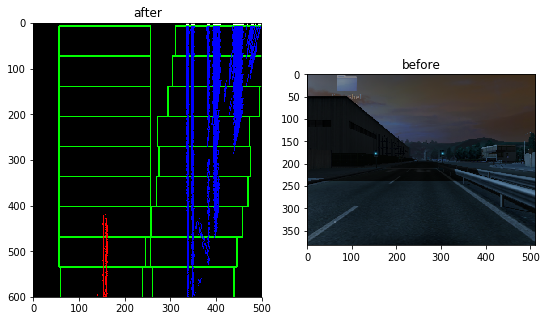

In [52]:
result = combine_threshold(select_white_yellow(image),apply_thresholds(image))
warped,minv = warp(result)
# Run the warped, binary image from the pipeline through the fitter
left_fit, right_fit, left_fit_m, right_fit_m, out_img = calc_line_fits(warped)

plt.figure(figsize=(9,9))
plt.subplot(121),plt.imshow(out_img)
plt.title('after')
plt.subplot(122),plt.imshow(image)
plt.title('before')

plt.show()

In [53]:
def calc_line_fits_from_prev(img, leftLine, rightLine):

    left_fit = leftLine.best_fit_px
    right_fit = rightLine.best_fit_px
    
    ### Settings
    margin = 100 # Width on either side of the fitted line to search

    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin))) 
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each in meters
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return left_fit, right_fit, left_fit_m, right_fit_m, result

In [54]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        
        # was the line detected in the last iteration?
        self.detected = False  
        
        # polynomial coefficients averaged over the last n iterations
        self.best_fit_px = None
        self.best_fit_m = None
        
        #polynomial coefficients for the most recent fit
        self.current_fit_px = None  
        self.current_fit_m = None
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        
        # center position of car
        self.lane_to_camera = None
        
        # Previous Fits
        self.previous_fits_px = []
        self.previous_fits_m = []
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        
        # meters per pixel in y dimension
        self.ym_per_pix = 30/720
        
        # y_eval is where we want to evaluate the fits for the line radius calcuation 
        # for us it's at the bottom of the image for us, and because we know 
        # the size of our video/images we can just hardcode it
        self.y_eval = 720. * self.ym_per_pix
        
        # camera position is where the camera is located relative to the image
        # we're assuming it's in the middle
        self.camera_position = 250.

    def run_line_pipe(self):
        self.calc_best_fit()
        self.calc_radius()
        
    def add_new_fit(self, new_fit_px, new_fit_m):
        """
        Add a new fit to the Line class
        """
        
        # If this is our first line, then we will have to take it
        if self.current_fit_px == None and self.previous_fits_px == []:
            self.detected = True
            self.current_fit_px = new_fit_px
            self.current_fit_m = new_fit_m
            self.run_line_pipe()
            return
        else:
            # measure the diff to the old fit
            self.diffs = np.abs(new_fit_px - self.current_fit_px)
            # check the size of the diff
            if self.diff_check():
                print("Found a fit diff that was too big")
                print(self.diffs)
                self.defected = False
                return
            self.detected = True
            self.current_fit_px = new_fit_px
            self.current_fit_m = new_fit_m
            self.run_line_pipe()
            return

            
    def diff_check(self):
        if self.diffs[0] > 0.001:
            return True
        if self.diffs[1] > 0.25:
            return True
        if self.diffs[2] > 1000.:
            return True
        return False

    def calc_best_fit(self):
        """
        calculate the average, if needed
        """
        # add the latest fit to the previous fit list
        self.previous_fits_px.append(self.current_fit_px)
        self.previous_fits_m.append(self.current_fit_m)
        
        # If we currently have 5 fits, throw the oldest out
        if len(self.previous_fits_px) > 5:
            self.previous_fits_px = self.previous_fits_px[1:]
        if len(self.previous_fits_m) > 5:
            self.previous_fits_m = self.previous_fits_m[1:]
        
        # Just average everything
        self.best_fit_px = np.average(self.previous_fits_px, axis=0)
        self.best_fit_m = np.average(self.previous_fits_m, axis=0)
        return
        
        
    def calc_radius(self):
        """
        left_fit and right_fit are assumed to have already been converted to meters
        """
        y_eval = self.y_eval
        fit = self.best_fit_m

        curve_rad = ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) / np.absolute(2*fit[0])
        self.radius_of_curvature = curve_rad
        return

In [55]:
def get_center_dist(leftLine, rightLine):
    
    # grab the x and y fits at px 700 (slightly above the bottom of the image)
    y = 700.
    image_center = 266. * xm_per_pix
    
    leftPos = leftLine.best_fit_px[0]*(y**2) + leftLine.best_fit_px[1]*y + leftLine.best_fit_px[2]
    rightPos = rightLine.best_fit_px[0]*(y**2) + rightLine.best_fit_px[1]*y + rightLine.best_fit_px[2]
    lane_middle = int((rightPos - leftPos)/2.)+leftPos
    lane_middle = lane_middle * xm_per_pix
    
    mag = lane_middle - image_center
    if (mag > 0):
        head = "Right"
    else:
        head = "Left"
            
    return head, mag

def combine_radii(leftLine, rightLine):
    
    left = leftLine.radius_of_curvature
    right = rightLine.radius_of_curvature
    
    return np.average([left, right])


In [56]:
def create_final_image(img, binary_warped, leftLine, rightLine, show_images=False):
    
    left_fit = leftLine.best_fit_px
    right_fit = rightLine.best_fit_px
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=20)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=20)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = unwarp(color_warp,img)
    
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.5, 0)
    
    if show_images:
        plt.figure(figsize=(9,9))
        plt.imshow(color_warp)
        
        plt.figure(figsize=(9,9))
        plt.imshow(result)
    
    return result

def add_image_text(img, radius, head, center):
    
    # Add the radius and center position to the image
    font = cv2.FONT_HERSHEY_DUPLEX
    
    text = 'Radius of curvature: ' + '{:04.0f}'.format(radius) + 'm'
    cv2.putText(img, text, (50,100), font, 1.5, (0,255, 0), 2, cv2.LINE_AA)

    text = '{:03.2f}'.format(abs(center)) + 'm '+ head + ' of center'
    cv2.putText(img, text, (50,175), font, 1.5, (0,255, 0), 2, cv2.LINE_AA)
    
    return img

In [57]:
def final_pipeline(img):
    
    img_og = np.copy(img)
      
    # Run this through our binary pipeline
    
    black_white = combine_threshold(select_white_yellow(image),apply_thresholds(image))
    binary_warped,minv = warp(black_white)
    
    # If we found lines previously, run the simplified line fitter
    if leftLine.detected == True and rightLine.detected == True:
        left_fit, right_fit, left_fit_m, right_fit_m, out_img = calc_line_fits_from_prev(binary_warped, leftLine, rightLine)
    else:
        # Run the warped, binary image from the pipeline through the complex fitter
        left_fit, right_fit, left_fit_m, right_fit_m, out_img = calc_line_fits(binary_warped)
    
    
    # Add these fits to the line classes
    leftLine.add_new_fit(left_fit, left_fit_m)
    rightLine.add_new_fit(right_fit, left_fit_m)
    
    # get radius and center distance
    curve_rad = combine_radii(leftLine, rightLine)
    head, center = get_center_dist(leftLine, rightLine)

    # create the final image
    result = create_final_image(img, binary_warped, leftLine, rightLine)
    
    # add the text to the image 
    result = add_image_text(result, curve_rad, head, center)
    
    return result

In [58]:
# Initialize two lines for left and right on every image since the images don't
# come from a continous video
rightLine = Line()
leftLine = Line()

In [59]:
# Read the image
image = cv2.imread('sct-50x64_1080x370.png')
result = final_pipeline(image)

# Let's plot the image
plt.figure(figsize=(9,9))
plt.imshow(result)

TypeError: expected non-empty vector for x